# MNIST

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Prepare the dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.30MB/s]


## Model(LeNet-5)

In [3]:
def conv_layers(activation):
    return nn.Sequential(
        nn.Conv2d(1, 6, 5, stride=1),
        activation(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, stride=1),
        activation(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(16, 120, 5, stride=1),
        activation()
    )

In [4]:
def fc_layers(activation):
    return nn.Sequential(
        nn.Linear(120, 84),
        activation(),
        nn.Linear(84, 10)
    )

In [5]:
class LeNet5(nn.Module):
    def __init__(self, activation=nn.Tanh):
        super(LeNet5, self).__init__()
        self.conv_layers = conv_layers(activation)
        self.fc_layers = fc_layers(activation)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 120)
        x = self.fc_layers(x)
        return x

## Functions

### Train

In [6]:
def train(model, train_loader, optimizer, loss_function):
    model.train()
    train_loss = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        total += data.size(0)

    avg_loss = train_loss / total
    train_losses.append(avg_loss)

### Test

In [7]:
def test(model, test_loader, loss_function, epoch, max_accuracy):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = loss_function(output, target)
            test_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)

    avg_test_loss = test_loss / total
    test_losses.append(avg_test_loss)

    accuracy = correct/total
    if accuracy > max_accuracy:
        max_accuracy = accuracy
    print(f'Epoch {epoch} - Accuracy: {accuracy}')

    return max_accuracy

### Visualization

In [8]:
def plot_loss(train_losses, test_losses, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(train_losses) + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Train vs Test Loss')
    plt.legend()
    plt.show()

## Main

[LeNet5_Tanh]
Epoch 0 - Accuracy: 0.9735
Epoch 1 - Accuracy: 0.9821
Epoch 2 - Accuracy: 0.9836
Epoch 3 - Accuracy: 0.9856
Epoch 4 - Accuracy: 0.9874
Epoch 5 - Accuracy: 0.9871
Epoch 6 - Accuracy: 0.9885
Epoch 7 - Accuracy: 0.9878
Epoch 8 - Accuracy: 0.9875
Epoch 9 - Accuracy: 0.9889
Max accuracy: 0.9889


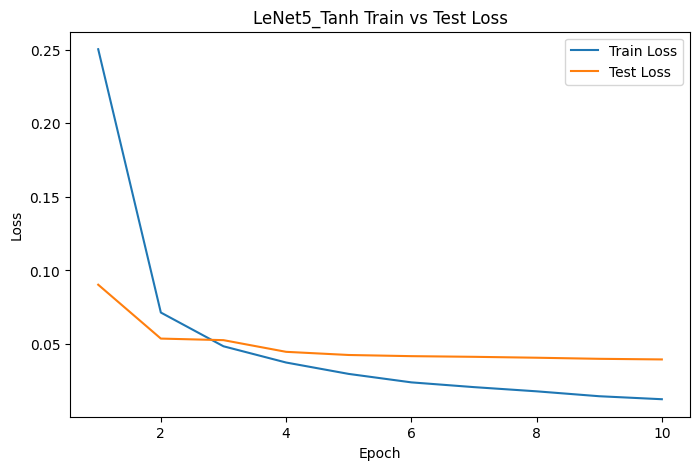

[LeNet5_ReLU]
Epoch 0 - Accuracy: 0.9615
Epoch 1 - Accuracy: 0.9791
Epoch 2 - Accuracy: 0.983
Epoch 3 - Accuracy: 0.9859
Epoch 4 - Accuracy: 0.989
Epoch 5 - Accuracy: 0.9895
Epoch 6 - Accuracy: 0.9887
Epoch 7 - Accuracy: 0.9886
Epoch 8 - Accuracy: 0.9905
Epoch 9 - Accuracy: 0.9885
Max accuracy: 0.9905


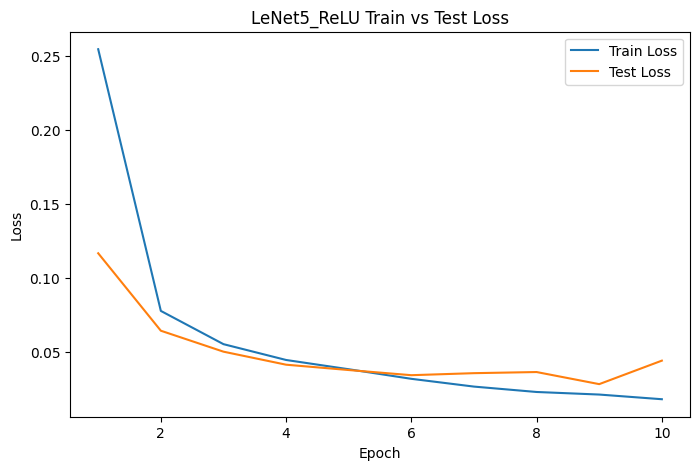

In [9]:
activations = {'LeNet5_Tanh': nn.Tanh, 'LeNet5_ReLU': nn.ReLU}
models = {}
epochs = 10

for model_name, act_fn in activations.items():
    print(f'[{model_name}]')

    model = LeNet5(activation=act_fn)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []
    max_accuracy = 0

    for epoch in range(epochs):
        train(model, train_loader, optimizer, loss_function)
        max_accuracy = test(model, test_loader, loss_function, epoch, max_accuracy)

    print(f'Max accuracy: {max_accuracy}')
    plot_loss(train_losses, test_losses, model_name)